# Libraries

In [89]:
import os
import librosa
from librosa.feature import melspectrogram
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

from PIL import Image
from tqdm import tqdm
from pathlib import Path

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score, classification_report

import torch
import torchvision
from torchvision.models import ResNet50_Weights, VGG16_Weights, DenseNet121_Weights
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.models as models
from torchvision.transforms import v2
from torch import nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR

# Hyperparameters

In [2]:
N_MELS = 128
N_FFT = 2048
HOP_LENGTH = 512
SAMPLE_DURATION = 5
RESIZE = 224

In [3]:
AUDIO_DIR = 'audio/'
SPECTROGRAM_DIR = 'spectrogram_224_5s/'
ANNOTATIONS_FILE = 'annotations.csv'
NUM_CLASSES = 4
EMOTION_CLASSES = ['Happy', 'Calm', 'Angry', 'Sad']
EMOTION_MAP = {
        0: 'Happy',
        1: 'Calm',
        2: 'Angry',
        3: 'Sad'
    }

# Utilities

In [4]:
def get_melsp(y, sr, resize, start_time, duration):
    """
    Generates a Mel-spectrogram image from a segment of an audio signal and normalizes it.
    
    Args:
        y (np.ndarray): Audio time-series data.
        sr (int): Sampling rate of the audio.
        resize (int): Size to resize the spectrogram image.
        start_time (float): Start time of the segment in seconds.
        duration (float): Duration of the segment in seconds.
    
    Returns:
        PIL.Image.Image: Image object of the Mel-spectrogram normalized and resized.
    """
    
    start_sample = int(start_time * sr)
    end_sample = start_sample + int(duration * sr)
    y_segment = y[start_sample:end_sample]
    
    mel_spect = librosa.feature.melspectrogram(y=y_segment, sr=sr, 
                                               n_mels=N_MELS, 
                                               n_fft=N_FFT,
                                               hop_length=HOP_LENGTH)
    mel_spect_db = librosa.power_to_db(mel_spect, ref=np.max)
    mel_spect_db = (mel_spect_db - mel_spect_db.min()) / (mel_spect_db.max() - mel_spect_db.min())
    
    return Image.fromarray(mel_spect_db * 255).convert('L').resize((resize, resize), Image.LANCZOS)

In [5]:
def map_arousal_valence_to_emotion(arousal, valence):
    """
    Maps arousal and valence values to discrete emotion classes.
    
    Args:
        arousal (float): Arousal value scaled from 1 to 9.
        valence (float): Valence value scaled from 1 to 9.
    
    Returns:
        int: Integer label corresponding to an emotion class.
            - 0: Happy
            - 1: Calm
            - 2: Angry
            - 3: Sad
            - -1: Undefined (if values do not fall into any defined range)
    """
    if 5 <= valence <= 9:
        if 5 <= arousal <= 9:
            return 0  # Happy
        elif 1 <= arousal < 5:
            return 1  # Calm
    elif 1 <= valence <= 5:
        if 5 <= arousal <= 9:
            return 2  # Angry
        elif 1 <= arousal < 5:
            return 3  # Sad
    
    return -1  # Undefined

In [84]:
def grayscale_to_rgb(image):
    return Image.merge("RGB", (image, image, image))

In [7]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [8]:
def train_and_validate(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, device, epochs, patience, train_losses, train_accuracies, test_losses, test_accuracies, all_true_labels, all_predicted_labels):
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        pbar_train = tqdm(train_dataloader, desc=f'Training Epoch {epoch+1}/{epochs}', unit='batch')

        for images, labels in pbar_train:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)

            # Calculate loss
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            pbar_train.set_postfix({'Loss': running_loss / (total if total > 0 else 1), 'Accuracy': 100. * correct / total})

        # Calculate average training loss and accuracy for the epoch
        epoch_train_loss = running_loss / len(train_dataloader)
        epoch_train_accuracy = 100. * correct / total

        # Append to lists
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_accuracy)

        # Print epoch summary after completing training phase
        print(f'Epoch {epoch+1}, Training Loss: {epoch_train_loss:.4f}, Training Accuracy: {epoch_train_accuracy:.2f}%')

        torch.cuda.empty_cache()

        scheduler.step()

        # Validation phase (early stopping evaluation)
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        pbar_val = tqdm(val_dataloader, desc=f'Validation Epoch {epoch+1}/{epochs}', unit='batch', leave=False)

        with torch.no_grad():
            for images, labels in pbar_val:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                # Calculate loss
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Calculate accuracy
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                # Collect true and predicted labels
                all_true_labels.extend(labels.cpu().numpy())
                all_predicted_labels.extend(predicted.cpu().numpy())

                pbar_val.set_postfix({'Loss': val_loss / (total if total > 0 else 1), 'Accuracy': 100. * correct / total})

        # Calculate average validation loss and accuracy for the epoch
        epoch_val_loss = val_loss / len(val_dataloader)
        epoch_val_accuracy = 100. * correct / total

        # Append to lists
        test_losses.append(epoch_val_loss)
        test_accuracies.append(epoch_val_accuracy)

        # Print epoch summary after completing validation phase
        print(f'Epoch {epoch+1}, Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_accuracy:.2f}%')

        # Check for early stopping
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            patience_counter = 0
            # Optionally save the model checkpoint here
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break

    # Calculate precision, recall, and F1-score at the end
    final_precision = precision_score(all_true_labels, all_predicted_labels, average='weighted')
    final_recall = recall_score(all_true_labels, all_predicted_labels, average='weighted')
    final_f1_score = f1_score(all_true_labels, all_predicted_labels, average='weighted')

    print(f'Final Precision: {final_precision:.4f}, Final Recall: {final_recall:.4f}, Final F1-Score: {final_f1_score:.4f}')


In [103]:
class ResultsAnalyzer:
    def __init__(self, train_losses, train_accuracies, test_losses, test_accuracies, all_true_labels, all_predicted_labels):
        self.train_losses = train_losses
        self.train_accuracies = train_accuracies
        self.test_losses = test_losses
        self.test_accuracies = test_accuracies
        self.all_true_labels = all_true_labels
        self.all_predicted_labels = all_predicted_labels

    def plot_losses_accuracies(self):
        epochs = range(1, len(self.train_losses) + 1)

        plt.figure(figsize=(14, 5))

        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.train_losses, 'r-', label='Training loss')
        plt.plot(epochs, self.test_losses, 'b-', label='Validation loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.train_accuracies, 'r-', label='Training accuracy')
        plt.plot(epochs, self.test_accuracies, 'b-', label='Validation accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()

    def plot_confusion_matrix(self):
        cm = confusion_matrix(self.all_true_labels, self.all_predicted_labels)
        plt.figure(figsize=(10, 7))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Happy', 'Calm', 'Angry', 'Sad'], yticklabels=['Happy', 'Calm', 'Angry', 'Sad'])
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

    def generate_classification_report(self):
        print(f"Final validation accuracy: {self.test_accuracies[-1]:.2f}%")
        print(classification_report(self.all_true_labels, self.all_predicted_labels, target_names=EMOTION_CLASSES))

# Get Data

In [33]:
# Convert audio to mel-spectrogram and save in SPECTROGRAM_DIR
if not os.path.exists(SPECTROGRAM_DIR):
    os.makedirs(SPECTROGRAM_DIR)
    print(f'Created directory: {SPECTROGRAM_DIR}')
    print('Processing audio files...')
    for filename in os.listdir(AUDIO_DIR):
        if filename.endswith('.mp3'):
            audio_path = os.path.join(AUDIO_DIR, filename)
            y, sr = librosa.load(audio_path, sr=None)
            
            # Split into 5-second segments and process each
            total_duration = librosa.get_duration(y=y, sr=sr)
            num_segments = int(total_duration // SAMPLE_DURATION)
            
            for i in range(num_segments):
                start_time = i * SAMPLE_DURATION
                spectrogram_filename = f'{os.path.splitext(filename)[0]}_segment_{i}.png'
                spectrogram_path = os.path.join(SPECTROGRAM_DIR, spectrogram_filename)
                
                mel_spect_img = get_melsp(y, sr, RESIZE, start_time, SAMPLE_DURATION)
                mel_spect_img.save(spectrogram_path)

print('Finished processing audio files.')

Created directory: spectrogram_224_5s/
Processing audio files...


C:\Users\User\AppData\Local\Temp\ipykernel_21048\1658101616.py:25: RuntimeWarning: invalid value encountered in divide
  mel_spect_db = (mel_spect_db - mel_spect_db.min()) / (mel_spect_db.max() - mel_spect_db.min())


Finished processing audio files.


# Create Dataset

In [64]:
class SpectrogramDataset(Dataset):
    EMOTION_MAP = {
        0: 'Happy',
        1: 'Calm',
        2: 'Angry',
        3: 'Sad'
    }

    def __init__(self, spectrogram_dir, annotations, transform=None):
        self.spectrogram_dir = spectrogram_dir
        self.annotations = annotations
        self.labels = annotations[[' valence_mean', ' arousal_mean']].to_numpy().astype(np.float32)
        self.transform = transform

        # Calculate emotion labels and append as a new column
        self.annotations['emotion_label'] = self.annotations.apply(
            lambda row: map_arousal_valence_to_emotion(row[' arousal_mean'], row[' valence_mean']),
            axis=1
        )

        # Expand annotations to include segment information
        self.segmented_annotations = []
        for idx, row in self.annotations.iterrows():
            song_id = int(row['song_id'])
            emotion_label = int(row['emotion_label'])
            for segment in range(9):  # 9 segments each for each song (45 seconds)
                img_path = os.path.join(self.spectrogram_dir, f'{song_id}_segment_{segment}.png')
                if os.path.exists(img_path):
                    self.segmented_annotations.append((song_id, segment, emotion_label))


    def __len__(self):
        return len(self.segmented_annotations)

    def __getitem__(self, idx):
        song_id, segment, emotion_label = self.segmented_annotations[idx]
        img_path = os.path.join(self.spectrogram_dir, f'{song_id}_segment_{segment}.png')

        # Load image
        image = Image.open(img_path).convert('L')
        image = grayscale_to_rgb(image)

        if self.transform:
            image = self.transform(image)

        return image, emotion_label


In [49]:
transform = v2.Compose([
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [65]:
annotations = pd.read_csv(ANNOTATIONS_FILE)
dataset = SpectrogramDataset(SPECTROGRAM_DIR, annotations, transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
print(f'Size of train dataset: {train_size}\nSize of test dataset: {test_size}')

Size of train dataset: 12549
Size of test dataset: 3138


# EDA

In [51]:
df = pd.DataFrame(dataset.segmented_annotations, columns=['song_id', 'segment', 'emotion_label'])

In [52]:
df.head()

,song_id,segment,emotion_label
0,2,0,Sad
1,2,1,Sad
2,2,2,Sad
3,2,3,Sad
4,2,4,Sad


In [53]:
df['emotion_label'].value_counts()

emotion_label
Sad      6036
Happy    5703
Calm     1998
Angry    1950
Name: count, dtype: int64

In [54]:
def plot_valence_arousal_distribution(df):
    plt.figure(figsize=(9, 6))
    
    plt.subplot(1, 2, 1)
    sns.histplot(df[' valence_mean'], kde=True, bins=30)
    plt.title('Distribution of Valence Mean')
    plt.xlabel('Valence Mean')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    sns.histplot(df[' arousal_mean'], kde=True, bins=30)
    plt.title('Distribution of Arousal Mean')
    plt.xlabel('Arousal Mean')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

def scatter_valence_arousal(df):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=' valence_mean', y=' arousal_mean', hue='emotion_label', data=df, palette='tab10')
    plt.title('Scatter Plot of Valence vs Arousal')
    plt.xlabel('Valence Mean')
    plt.ylabel('Arousal Mean')
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
    plt.show()

def barplot_emotion_counts(df):
    plt.figure(figsize=(10, 6))
    sns.countplot(x='emotion_label', hue='emotion_label', data=df, palette='tab10', order=df['emotion_label'].value_counts().index, legend=False)
    plt.title('Counts of Each Emotion Label')
    plt.xlabel('Emotion Label')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

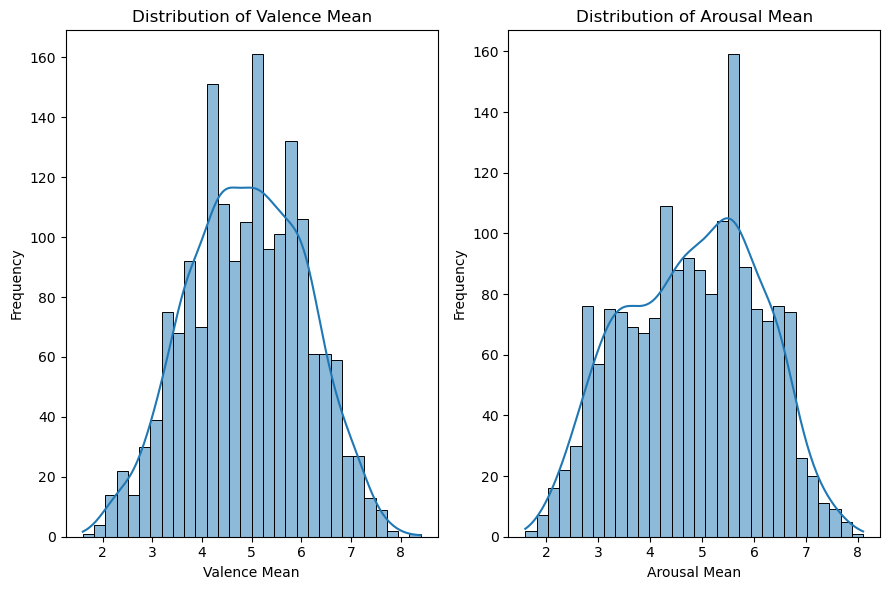

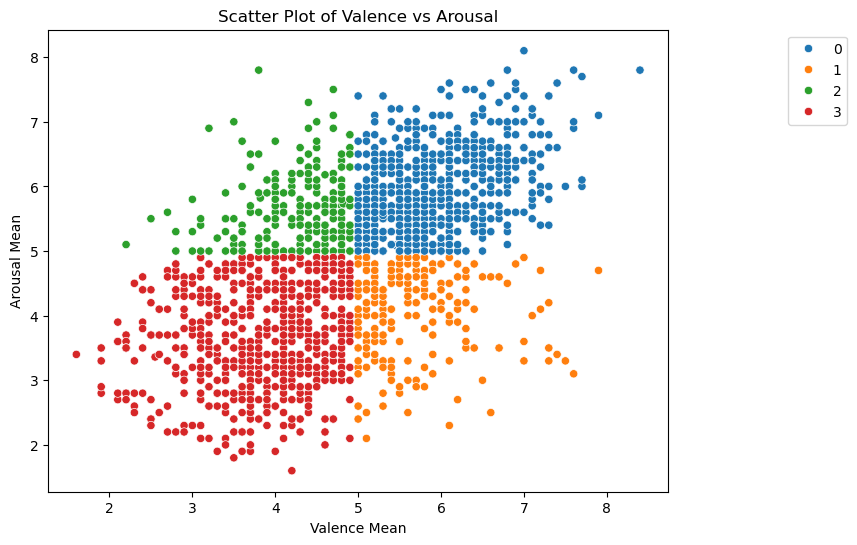

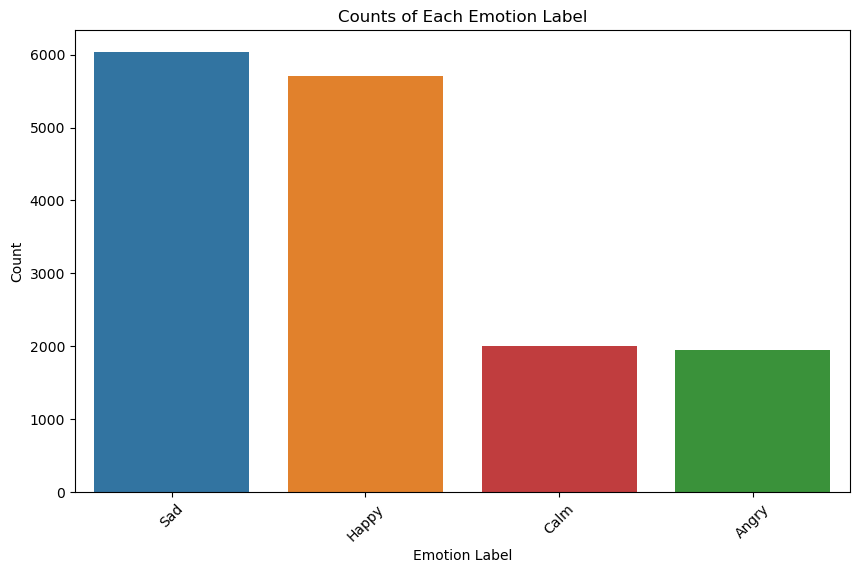

In [70]:
plot_valence_arousal_distribution(annotations)
scatter_valence_arousal(annotations)
barplot_emotion_counts(df)

# Define Models

In [56]:
class ResNet50(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50, self).__init__()
        self.resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

In [57]:
class VGG16(nn.Module):
    def __init__(self, num_classes):
        super(VGG16, self).__init__()
        self.vgg16 = models.vgg16(weights=VGG16_Weights.DEFAULT)
        num_features = self.vgg16.classifier[6].in_features
        self.vgg16.classifier[6] = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.vgg16(x)

In [58]:
class DenseNet121(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.densenet = models.densenet121(weights=DenseNet121_Weights.DEFAULT)
        num_features = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Linear(num_features, num_classes)
    
    def forward(self, x):
        return self.densenet(x)

# Train and Test Models

In [59]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [60]:
df['emotion_label'].value_counts()

emotion_label
Sad      6036
Happy    5703
Calm     1998
Angry    1950
Name: count, dtype: int64

In [61]:
class_counts = {'Happy': 5703, 'Calm': 1998, 'Angry': 1950, 'Sad': 6036}
total_samples = sum(class_counts.values())
class_weights = [total_samples / (len(class_counts) * count) for count in class_counts.values()]
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
class_weights

tensor([0.6877, 1.9628, 2.0112, 0.6497], device='cuda:0')

## ResNet50

In [66]:
set_seed(616)
resnet50_model = ResNet50(NUM_CLASSES)

RN_EPOCHS = 20
RN_LEARNING_RATE = 0.001
RN_BATCH_SIZE = 8

rn_train_dataloader = DataLoader(train_dataset, batch_size=RN_BATCH_SIZE, shuffle=True)
rn_val_dataloader = DataLoader(test_dataset, batch_size=RN_BATCH_SIZE, shuffle=False)

rn_criterion = nn.CrossEntropyLoss(weight=class_weights)
rn_optimizer = optim.Adam(resnet50_model.parameters(), lr=RN_LEARNING_RATE)
rn_scheduler = StepLR(rn_optimizer, step_size=5, gamma=0.1)

rn_train_losses, rn_train_accuracies = [], []
rn_test_losses, rn_test_accuracies = [], []
rn_all_true_labels, rn_all_predicted_labels = [], []

resnet50_model.to(device)

ResNet50(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          

In [67]:
train_and_validate(
    model=resnet50_model,
    train_dataloader=rn_train_dataloader,
    val_dataloader=rn_val_dataloader,
    criterion=rn_criterion,
    optimizer=rn_optimizer,
    scheduler=rn_scheduler,
    device=device,
    epochs=RN_EPOCHS,
    patience=5,
    train_losses=rn_train_losses,
    train_accuracies=rn_train_accuracies,
    test_losses=rn_test_losses,
    test_accuracies=rn_test_accuracies,
    all_true_labels=rn_all_true_labels,
    all_predicted_labels=rn_all_predicted_labels
)

Training Epoch 1/20: 100%|███████████████████████████| 1569/1569 [13:55<00:00,  1.88batch/s, Loss=0.152, Accuracy=56.3]


Epoch 1, Training Loss: 1.2162, Training Accuracy: 56.32%


Epoch 1, Validation Loss: 1.1384, Validation Accuracy: 61.79%


Training Epoch 2/20: 100%|███████████████████████████| 1569/1569 [11:54<00:00,  2.19batch/s, Loss=0.147, Accuracy=58.5]


Epoch 2, Training Loss: 1.1737, Training Accuracy: 58.45%


Epoch 2, Validation Loss: 1.3101, Validation Accuracy: 46.34%


Training Epoch 3/20: 100%|███████████████████████████| 1569/1569 [12:31<00:00,  2.09batch/s, Loss=0.142, Accuracy=60.2]


Epoch 3, Training Loss: 1.1378, Training Accuracy: 60.16%


Epoch 3, Validation Loss: 1.1646, Validation Accuracy: 63.48%


Training Epoch 4/20: 100%|████████████████████████████| 1569/1569 [12:55<00:00,  2.02batch/s, Loss=0.14, Accuracy=59.9]


Epoch 4, Training Loss: 1.1206, Training Accuracy: 59.95%


Epoch 4, Validation Loss: 1.1541, Validation Accuracy: 50.35%


Training Epoch 5/20: 100%|███████████████████████████| 1569/1569 [14:00<00:00,  1.87batch/s, Loss=0.137, Accuracy=60.4]


Epoch 5, Training Loss: 1.0982, Training Accuracy: 60.36%


Epoch 5, Validation Loss: 1.1081, Validation Accuracy: 55.90%


Training Epoch 6/20: 100%|█████████████████████████████| 1569/1569 [13:41<00:00,  1.91batch/s, Loss=0.125, Accuracy=65]


Epoch 6, Training Loss: 0.9975, Training Accuracy: 65.04%


Epoch 6, Validation Loss: 0.9579, Validation Accuracy: 66.06%


Training Epoch 7/20: 100%|███████████████████████████| 1569/1569 [13:25<00:00,  1.95batch/s, Loss=0.119, Accuracy=66.4]


Epoch 7, Training Loss: 0.9520, Training Accuracy: 66.41%


Epoch 7, Validation Loss: 0.9364, Validation Accuracy: 66.38%


Training Epoch 8/20: 100%|███████████████████████████| 1569/1569 [13:26<00:00,  1.95batch/s, Loss=0.113, Accuracy=68.1]


Epoch 8, Training Loss: 0.9038, Training Accuracy: 68.15%


Epoch 8, Validation Loss: 0.9165, Validation Accuracy: 66.38%


Training Epoch 9/20: 100%|███████████████████████████| 1569/1569 [13:29<00:00,  1.94batch/s, Loss=0.107, Accuracy=69.7]


Epoch 9, Training Loss: 0.8537, Training Accuracy: 69.69%


Epoch 9, Validation Loss: 0.9097, Validation Accuracy: 67.56%


Training Epoch 10/20: 100%|████████████████████████████| 1569/1569 [13:26<00:00,  1.95batch/s, Loss=0.1, Accuracy=71.6]


Epoch 10, Training Loss: 0.8002, Training Accuracy: 71.56%


Epoch 10, Validation Loss: 0.8903, Validation Accuracy: 68.83%


Training Epoch 11/20: 100%|██████████████████████████| 1569/1569 [13:25<00:00,  1.95batch/s, Loss=0.091, Accuracy=74.7]


Epoch 11, Training Loss: 0.7275, Training Accuracy: 74.71%


Epoch 11, Validation Loss: 0.8671, Validation Accuracy: 69.15%


Training Epoch 12/20: 100%|█████████████████████████| 1569/1569 [13:13<00:00,  1.98batch/s, Loss=0.0894, Accuracy=74.7]


Epoch 12, Training Loss: 0.7150, Training Accuracy: 74.73%


Epoch 12, Validation Loss: 0.8775, Validation Accuracy: 69.57%


Training Epoch 13/20: 100%|█████████████████████████| 1569/1569 [13:35<00:00,  1.92batch/s, Loss=0.0867, Accuracy=75.4]


Epoch 13, Training Loss: 0.6937, Training Accuracy: 75.38%


Epoch 13, Validation Loss: 0.8629, Validation Accuracy: 69.28%


Training Epoch 14/20: 100%|█████████████████████████| 1569/1569 [13:01<00:00,  2.01batch/s, Loss=0.0861, Accuracy=75.9]


Epoch 14, Training Loss: 0.6887, Training Accuracy: 75.86%


Epoch 14, Validation Loss: 0.8685, Validation Accuracy: 69.92%


Training Epoch 15/20: 100%|█████████████████████████| 1569/1569 [12:58<00:00,  2.02batch/s, Loss=0.0838, Accuracy=76.5]


Epoch 15, Training Loss: 0.6699, Training Accuracy: 76.51%


Epoch 15, Validation Loss: 0.8731, Validation Accuracy: 70.97%


Training Epoch 16/20: 100%|█████████████████████████| 1569/1569 [12:58<00:00,  2.02batch/s, Loss=0.0826, Accuracy=76.9]


Epoch 16, Training Loss: 0.6607, Training Accuracy: 76.88%


Epoch 16, Validation Loss: 0.8693, Validation Accuracy: 70.30%


Training Epoch 17/20: 100%|█████████████████████████| 1569/1569 [13:29<00:00,  1.94batch/s, Loss=0.0824, Accuracy=76.7]


Epoch 17, Training Loss: 0.6587, Training Accuracy: 76.67%


Epoch 17, Validation Loss: 0.8694, Validation Accuracy: 69.92%


Training Epoch 18/20: 100%|█████████████████████████| 1569/1569 [13:45<00:00,  1.90batch/s, Loss=0.0829, Accuracy=76.6]


Epoch 18, Training Loss: 0.6630, Training Accuracy: 76.62%


Epoch 18, Validation Loss: 0.8692, Validation Accuracy: 70.30%
Early stopping triggered after 18 epochs
Final Precision: 0.6914, Final Recall: 0.6514, Final F1-Score: 0.6668


In [105]:
torch.cuda.empty_cache()

Final validation accuracy: 70.30%
              precision    recall  f1-score   support

       Happy       0.82      0.68      0.74     20610
        Calm       0.35      0.46      0.39      6912
       Angry       0.32      0.44      0.37      6732
         Sad       0.79      0.75      0.77     22230

    accuracy                           0.65     56484
   macro avg       0.57      0.58      0.57     56484
weighted avg       0.69      0.65      0.67     56484



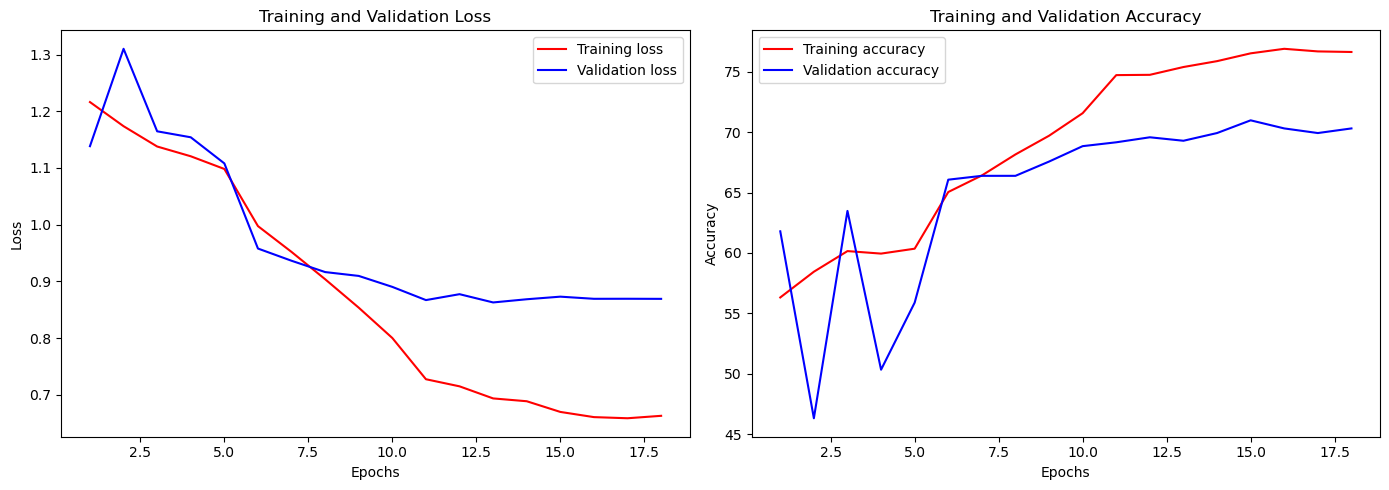

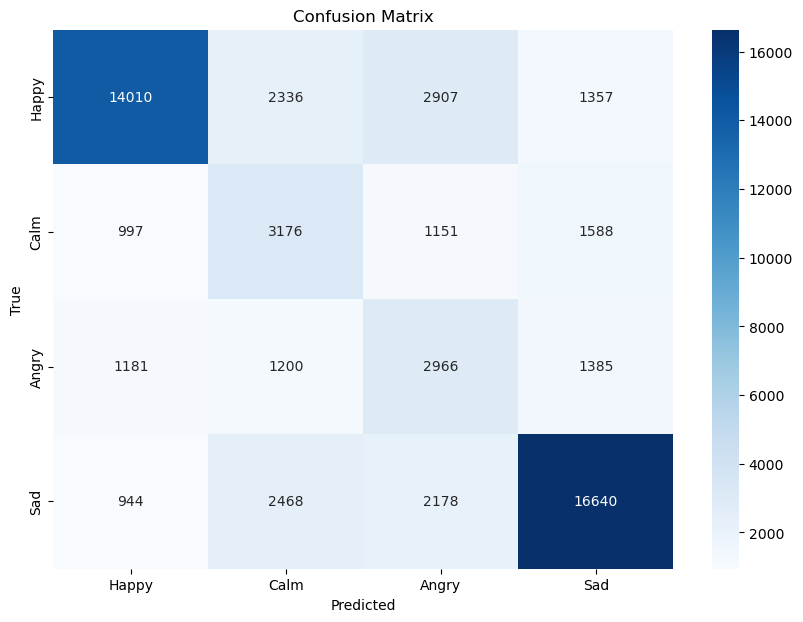

In [104]:
analyzer = ResultsAnalyzer(rn_train_losses, rn_train_accuracies, rn_test_losses, rn_test_accuracies, rn_all_true_labels, rn_all_predicted_labels)
analyzer.generate_classification_report()
analyzer.plot_losses_accuracies()
analyzer.plot_confusion_matrix()